# Worksheet 11

Name:  Quan Ho

UID: U17207751

### Topics

- Latent Semantic Analysis

### Latent Semantic Analysis

In this section we will fetch news articles from 3 different categories. We will perform Tfidf vectorization on the corpus of documents and use SVD to represent our corpus in the feature space of topics that we've uncovered from SVD. We will attempt to cluster the documents into 3 clusters as we vary the number of singular vectors we use to represent the corpus, and compare the output to the clustering created by the news article categories. Do we end up with a better clustering the more singular vectors we use?

In [1]:
import nltk
nltk.download('punkt') # Jupyter Notebook
#nltk.download('stopwords') Use on Google Collab(for this worksheet, not recomended)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ji619\anaconda3\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

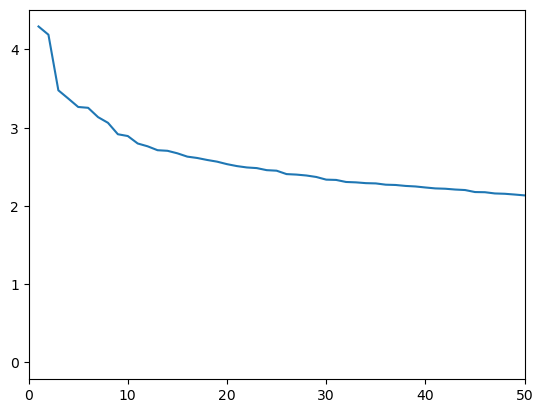

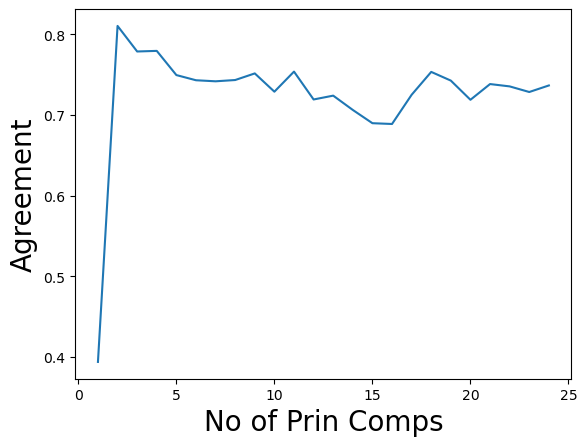

In [2]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize

categories = ['comp.os.ms-windows.misc', 'sci.space','rec.sport.baseball']
news_data = fetch_20newsgroups(subset='train', categories=categories)
vectorizer = TfidfVectorizer(stop_words='english', min_df=4,max_df=0.8)

stemmed_data = [" ".join(SnowballStemmer("english", ignore_stopwords=True).stem(word)  
         for sent in sent_tokenize(message)
        for word in word_tokenize(sent))
        for message in news_data.data]

dtm = vectorizer.fit_transform(stemmed_data)
terms = vectorizer.get_feature_names_out()
centered_dtm = dtm - np.mean(dtm, axis=0)

u, s, vt = np.linalg.svd(centered_dtm)
plt.xlim([0,50])
plt.plot(range(1,len(s)+1),s)
plt.show()

ag = []
max = len(u)
for k in range(1,25):
    vectorsk = u.dot(np.diag(s))[:,:k]
    kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=10, random_state=0)
    kmeans.fit_predict(np.asarray(vectorsk))
    labelsk = kmeans.labels_
    ag.append(metrics.v_measure_score(labelsk, news_data.target)) # closer to 1 means closer to news categories

plt.plot(range(1,25),ag)
plt.ylabel('Agreement',size=20)
plt.xlabel('No of Prin Comps',size=20)
plt.show()


By plotting the agreement scores against the number of principal components, we can observe whether increasing the number of singular vectors leads to better clustering performance. If the agreement score improves as we increase the number of principal components, it indicates that using more singular vectors provides a better representation of the data and improves clustering performance. Conversely, if the agreement score decreases or remains unchanged, adding more singular vectors may not be beneficial. From the graph, it looks like the aggreement score reaches its peak when 2 to 3 pinrciple components were used suggesting that 2 to 3 principal components provides the optimal balance between capturing meaningful information from the data and avoiding overfitting. Rhe additional components(beyond the 2 to 3 principal components) might capture more noise or less relevant information, leading to a decrease in clustering performance.

### Embeddings

The data comes from the [Yelp Dataset](https://www.yelp.com/dataset). Each line is a review that consists of a label (0 for negative reviews and 1 for positive reviews) and a set of words.

```
1 i will never forget this single breakfast experience in mad...
0 the search for decent chinese takeout in madison continues ...
0 sorry but me julio fell way below the standard even for med...
1 so this is the kind of food that will kill you so there s t...
```

In order to transform the set of words into vectors, we will rely on a method of feature engineering called word embeddings (Tfidf is one way to get these embeddings). Rather than simply indicating which words are present, word embeddings represent each word by "embedding" it in a low-dimensional vector space which may carry more information about the semantic meaning of the word. (for example in this space, the words "King" and "Queen" would be close).

`word2vec.txt` contains the `word2vec` embeddings for about 15 thousand words. Not every word in each review is present in the provided `word2vec.txt` file. We can treat these words as being "out of vocabulary" and ignore them.

### Example

Let x_i denote the sentence `“a hot dog is not a sandwich because it is not square”` and let a toy word2vec dictionary be as follows:

```
hot      0.1     0.2     0.3
not      -0.1    0.2     -0.3
sandwich 0.0     -0.2    0.4
square   0.2     -0.1    0.5
```

we would first `trim` the sentence to only contain words in our vocabulary: `"hot not sandwich not square”` then embed x_i into the feature space:

$$ φ2(x_i)) = \frac{1}{5} (word2vec(\text{hot}) + 2 · word2vec(\text{not}) + word2vec(\text{sandwich}) + word2vec(\text{square})) = \left[0.02 \hspace{2mm} 0.06 \hspace{2mm} 0.12 \hspace{2mm}\right]^T $$

a) Implement a function to trim out-of-vocabulary words from the reviews. Your function should return an nd array of the same dimension and dtype as the original loaded dataset. (10pts)

In [3]:
import csv
import numpy as np

VECTOR_LEN = 200   # Length of word2vec vector
MAX_WORD_LEN = 64  # Max word length in dict.txt and word2vec.txt

def load_tsv_dataset(file):
    """
    Loads raw data and returns a tuple containing the reviews and their ratings.

    Parameters:
        file (str): File path to the dataset tsv file.

    Returns:
        An np.ndarray of shape N. N is the number of data points in the tsv file.
        Each element dataset[i] is a tuple (label, review), where the label is
        an integer (0 or 1) and the review is a string.
    """
    dataset = np.loadtxt(file, delimiter='\t', comments=None, encoding='utf-8',
                         dtype='l,O')
    return dataset


def load_feature_dictionary(file):
    """
    Creates a map of words to vectors using the file that has the word2vec
    embeddings.

    Parameters:
        file (str): File path to the word2vec embedding file.

    Returns:
        A dictionary indexed by words, returning the corresponding word2vec
        embedding np.ndarray.
    """
    word2vec_map = dict()
    with open(file) as f:
        read_file = csv.reader(f, delimiter='\t')
        for row in read_file:
            word, embedding = row[0], row[1:]
            word2vec_map[word] = np.array(embedding, dtype=float)
    return word2vec_map


def trim_reviews(path_to_dataset, word2vec_map):
    """
    Preprocesses the reviews by trimming them to contain only words in the vocabulary
    and then embedding them into the feature space.

    Parameters:
        path_to_dataset (str): File path to the dataset tsv file.
        word2vec_map (dict): Dictionary containing word embeddings.

    Returns:
        Trimmed and embedded reviews.
    """
    dataset = load_tsv_dataset(path_to_dataset)
    trimmed_embedded_reviews = []
    for _, review in dataset:
        trimmed_review = []
        for word in review.split():
            if word in word2vec_map:
                trimmed_review.append(word2vec_map[word])

        # Calculate embedded feature vector using the trim equation above
        embedded_feature_vector = np.sum(trimmed_review, axis=0) / len(trimmed_review)

        trimmed_embedded_reviews.append(embedded_feature_vector)
    return trimmed_embedded_reviews

# Load word2vec map
word2vec_map = load_feature_dictionary('word2vec.txt')

# Trim and embed reviews
trim_train = trim_reviews('train_small.tsv', word2vec_map)
trim_test = trim_reviews('test_small.tsv', word2vec_map)

# Example usage to print embedded feature vectors
for embedded_feature_vector in trim_train:
    print("Embedded Feature Vector:", embedded_feature_vector)


Embedded Feature Vector: [-1.66646018e-01  6.41026549e-01 -6.48053097e-02  1.79902655e-01
  7.58946903e-01 -9.67097345e-01 -1.19115044e+00 -2.29079646e-01
  4.17796460e-01  1.16079646e-01 -5.54292035e-01  4.63389381e-01
 -6.91079646e-01  8.20955752e-01 -3.17469027e-01  2.93513274e-01
 -1.19477876e+00 -5.07362832e-01 -4.45681416e-01  1.53669912e+00
 -1.40284956e+00  1.29318584e+00  2.06079646e-01  6.46132743e-01
  5.21061947e-01  1.71594690e+00 -1.31963717e+00  2.26681416e-01
 -2.65699115e-01 -4.27716814e-01 -7.03017699e-01 -1.09171681e+00
 -7.33920354e-01 -8.85557522e-01  1.50001770e+00  1.64640708e+00
  1.72471681e+00 -1.06955752e+00  1.22292035e+00 -1.80577876e+00
 -8.64893805e-01 -6.76991150e-03  9.33628319e-03 -1.12483186e+00
 -2.40803540e+00 -1.14992920e+00 -6.69646018e-02  1.16514159e+00
 -1.54790265e+00  1.29176991e-01  9.91371681e-01 -1.10922124e+00
 -1.57778761e-01  1.97399115e+00  2.04044248e+00  1.73777876e+00
 -9.25398230e-01 -1.79235398e+00 -6.75964602e-01 -5.57256637e-02


#Sample 1
input1= 'train_small.tsv'
load_tsv_dataset(input1)

In [5]:
#Sample 2
input2 = 'test_small.tsv'
load_tsv_dataset(input2)

array([(0, 'i got the nuro virus from this place not having a sanitary enough salad bar and was throwing up so much the next day that i needed to get an iv injected into me at the student health center i have had much better experiences in there in the past and the food is undoubtedly very tasty however after almost having to get an ambulance because i was so drained from food poisoning the nuro virus the serve yourself salad bar atmosphere suddenly lost the all you cant eat appeal and was replaced with a visage of a slightly upscale version of an all you can eat las vegas strip club with less of the grotesque entertainment but all of the bacteria who needs a walk up style menu any ways last time i had that was at a continental breakfast at a marriott hotel i should have kept it that way'),
       (0, 'we came for the live music which was great i love that they have bands there on the weekends but the food and drinks weren t great i had a margarita which was way too sweet i sent it bac

In [6]:
load_feature_dictionary('word2vec.txt')

{'films': array([-0.598, -0.622, -0.637,  4.742,  4.323, -5.98 ,  0.041, -0.347,
         6.242, -0.993,  0.677, -3.917,  2.234,  2.427, -0.545,  0.416,
        -3.098, -2.478,  0.253,  2.621, -4.603, -0.51 ,  4.727,  2.03 ,
         0.44 ,  5.423, -2.83 , -1.781, -1.594, -0.663,  3.576, -3.337,
        -0.709, -1.091,  3.941,  0.733, -0.061, -3.294,  2.733, -1.26 ,
        -0.718,  1.358, -1.824,  2.059, -2.9  ,  0.045, -0.137,  4.932,
        -1.622,  1.493,  1.891, -4.366, -0.215,  4.069,  4.091,  4.278,
         1.388, -0.362, -0.588, -1.028,  0.623,  3.539,  4.096,  1.518,
         1.613,  1.044,  1.484, -1.391, -2.622,  3.509, -0.017, -0.895,
        -5.049, -0.36 , -2.286, -2.159, -3.816, -4.28 , -2.487, -1.138,
        -3.771,  3.284, -2.508,  1.959, -2.008, -0.353, -3.135,  3.741,
         0.779,  0.706,  1.105,  0.595,  1.947, -1.526, -0.734,  1.055,
        -1.55 ,  0.514,  0.273,  3.086,  0.759,  1.576,  1.122, -0.657,
        -0.324,  1.138,  0.921, -0.503, -5.976,  3.982,

In [7]:
expected_output1 = 'embedded_train_small.tsv'
load_tsv_dataset(expected_output1)
#This loads the first value of each arry

array([(1, '-0.166646'), (0, '-0.224874'), (0, '-0.222178'),
       (1, '-0.215923'), (1, '-0.190994'), (0, '-0.215320'),
       (0, '-0.209725'), (1, '-0.222648'), (0, '-0.255216'),
       (1, '-0.185746'), (0, '-0.219709'), (0, '-0.212043'),
       (0, '-0.197932'), (0, '-0.208037'), (1, '-0.249981'),
       (1, '-0.232048'), (1, '-0.226378'), (0, '-0.212480'),
       (1, '-0.221929'), (1, '-0.202339')],
      dtype=[('f0', '<i4'), ('f1', 'O')])

In [8]:
trim_train = trim_reviews('train_small.tsv', word2vec_map)
trim_train
#The values after array([ all matches

[array([-1.66646018e-01,  6.41026549e-01, -6.48053097e-02,  1.79902655e-01,
         7.58946903e-01, -9.67097345e-01, -1.19115044e+00, -2.29079646e-01,
         4.17796460e-01,  1.16079646e-01, -5.54292035e-01,  4.63389381e-01,
        -6.91079646e-01,  8.20955752e-01, -3.17469027e-01,  2.93513274e-01,
        -1.19477876e+00, -5.07362832e-01, -4.45681416e-01,  1.53669912e+00,
        -1.40284956e+00,  1.29318584e+00,  2.06079646e-01,  6.46132743e-01,
         5.21061947e-01,  1.71594690e+00, -1.31963717e+00,  2.26681416e-01,
        -2.65699115e-01, -4.27716814e-01, -7.03017699e-01, -1.09171681e+00,
        -7.33920354e-01, -8.85557522e-01,  1.50001770e+00,  1.64640708e+00,
         1.72471681e+00, -1.06955752e+00,  1.22292035e+00, -1.80577876e+00,
        -8.64893805e-01, -6.76991150e-03,  9.33628319e-03, -1.12483186e+00,
        -2.40803540e+00, -1.14992920e+00, -6.69646018e-02,  1.16514159e+00,
        -1.54790265e+00,  1.29176991e-01,  9.91371681e-01, -1.10922124e+00,
        -1.5

In [9]:
expected_output2 = 'embedded_test_small.tsv'
load_tsv_dataset(expected_output2)

array([(0, '-0.203273'), (0, '-0.231991'), (1, '-0.211579'),
       (1, '-0.210704'), (0, '-0.222390'), (1, '-0.220395'),
       (1, '-0.226557'), (0, '-0.223464')],
      dtype=[('f0', '<i4'), ('f1', 'O')])

In [10]:
trim_test = trim_reviews('test_small.tsv', word2vec_map)
trim_test
#The values after array([ all matches

[array([-2.03273381e-01,  4.25525180e-01, -1.43158273e-01,  1.29158273e-01,
         4.69647482e-01, -8.70834532e-01, -8.06604317e-01, -1.72143885e-01,
        -2.04553957e-01,  1.03676259e-01, -6.85107914e-01,  4.43410072e-01,
        -6.07143885e-01,  5.44330935e-01, -1.73151079e-01, -2.31690647e-01,
        -1.04433813e+00, -3.19640288e-02, -2.48525180e-01,  1.27947482e+00,
        -1.16829496e+00,  1.29961871e+00,  3.67287770e-01,  5.49208633e-01,
         4.52395683e-01,  1.83592806e+00, -9.23388489e-01,  2.38273381e-01,
        -3.01043165e-01, -6.29985612e-01, -5.41316547e-01, -1.00387050e+00,
        -5.53553957e-01, -5.92776978e-01,  1.80529496e+00,  1.61985612e+00,
         1.60260432e+00, -6.80733813e-01,  1.12127338e+00, -2.20952518e+00,
        -6.77978417e-01, -3.49661871e-01,  1.06345324e-01, -9.95791367e-01,
        -2.58359712e+00, -1.02240288e+00, -2.95323741e-01,  1.81712230e+00,
        -1.27849640e+00,  2.02892086e-01,  7.08388489e-01, -8.54172662e-01,
         3.5

In [11]:
import numpy as np

def calculate_sum_per_array(trim_data):
    sums = []
    for array in trim_data:
        array_sum = np.sum(array)
        sums.append(array_sum)
    return sums
sums_train = calculate_sum_per_array(trim_train)
sums_test = calculate_sum_per_array(trim_test)

# Print sums for trim_train
print("Sum per array in trim_train:")
for i, s in enumerate(sums_train):
    print(f"Array {i + 1}: {s}")

# Print sums for trim_test
print("\nSum per array in trim_test:")
for i, s in enumerate(sums_test):
    print(f"Array {i + 1}: {s}")


Sum per array in trim_train:
Array 1: 17.243557522123897
Array 2: 23.743621052631575
Array 3: 21.057606177606182
Array 4: 15.382593548387097
Array 5: 19.644896969696973
Array 6: 19.92544262295081
Array 7: 18.374532163742693
Array 8: 15.498942622950816
Array 9: 11.061632000000003
Array 10: 16.875751351351347
Array 11: 17.921213592233
Array 12: 23.326063829787234
Array 13: 20.332159090909098
Array 14: 20.36057407407408
Array 15: 15.20966666666666
Array 16: 14.502283132530128
Array 17: 24.93437837837837
Array 18: 21.085252049180337
Array 19: 22.966867346938773
Array 20: 15.514155963302748

Sum per array in trim_test:
Array 1: 21.614640287769788
Array 2: 17.74456896551724
Array 3: 21.796408805031437
Array 4: 15.997845965770159
Array 5: 17.490228571428563
Array 6: 15.26380864197531
Array 7: 14.169208053691266
Array 8: 13.280264000000004
